# Latent Dimensions I: Matrix Factorization

First, we need some data. Let's get a bunch of reviews

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# read in the data and transform it
df = pd.read_excel('../data/reviews.xlsx', nrows=100000)
df = df[df.clean_text.isna()==False] # drop all reviews without text
documents = df.clean_text.apply(str).tolist() # make sure they are strings

In [2]:
df

,Unnamed: 0,category,text,clean_text
0,0,Beauty and Wellness,there was an issue with the delivery but this ...,issue delivery resolve quickly complete care s...
1,1,Computer & Accessories,i found the item i was looking for quickly on ...,find item look quickly web site place order to...
2,2,Bathroom,part ordered monday pm and received it next day .,order monday pm receive day
3,3,Cell phone Recycling,the day the phone was received i had the money...,day phone receive money bank
4,4,Flowers,"flowers were beautiful , delivered on time and...",flower beautiful deliver time notify progress ...
...,...,...,...,...
99995,99995,Pets,i 've been using viovet for quite a few years ...,ve viovet year reason complain find previous c...
99996,99996,Pets,we have been using vio vet for some time and h...,vio vet time find service rate quick prompt de...
99997,99997,Beauty and Wellness,do nt bother going out to shop wasting valuabl...,nt bother go shop waste valuable time want che...
99998,99998,Batteries & Power Supply,werry god i can recomend toolstop to buy tools...,recomend toolstop buy tool item right price


In [2]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(99973, 2444)


## SVD

SVD decomposes the data into three components: the document view `U`, the singular values `S`, and the term view `V`.

In [3]:
from sklearn.decomposition import TruncatedSVD # this also works with sparse matrices

# set number of latent components
k = 20

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

Wall time: 2.38 s


The three matrices have the respective sizes of the initial matrix and the latent dimensions (note that `S` here is a vector, rather than a square matrix)

In [4]:
print(U.shape, S.shape, V.shape)

(99973, 20) (20,) (20, 2444)


Let's take a look at the latent dimensions (= singular values):

In [5]:
S

array([50.31098776, 31.33087208, 29.01514578, 26.78094098, 25.55720646,
       25.05322292, 23.92783896, 22.65239571, 22.0535604 , 21.87801291,
       21.61366481, 20.66806767, 20.45841732, 20.09208723, 20.08064668,
       19.69148962, 19.28191615, 19.08760221, 18.60954257, 18.26626388])

## NMF

NMF provides only two components: the document view `W`, and the term view `H`.

In [6]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

Wall time: 57.3 s


Again, the matrices have the respective sizes of the initial matrix and the latent dimensions

In [7]:
print(W.shape, H.shape)

(99973, 20) (20, 2444)


## Latent topics

We can use the term views `V` (from SVD) and `H` (from NMF) to describe the latent concept dimensions.

In [8]:
import numpy as np
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]


Here are the terms from SVD:

In [9]:
terms = tfidf_vectorizer.get_feature_names()

show_topics(V, terms)

['service, order, good, day, price',
 'phone, send, day, money, mazuma',
 'order, flower, deliver, day, arrive',
 'easy, use, easy use, website, flower',
 'service, flower, excellent, great, fast',
 'tyre, service, fit, time, recommend',
 'flower, good, good price, deliver, price',
 'great, delivery, tyre, fast, fast delivery',
 'quick, service, easy, quick delivery, excellent',
 'great, great service, great price, quickly, arrive',
 'quick, recommend, quick delivery, company, product',
 'time, fast, quickly, mazuma, arrive',
 'product, excellent, money, buy, value',
 'money, value, value money, good value, good',
 'arrive, arrive day, time, day, flower',
 'time, deliver, excellent, price, money',
 'excellent, quickly, arrive, excellent service, arrive quickly',
 'site, web, web site, site easy, item',
 'product, day, fast, deliver, quality',
 'receive, item, quickly, site, send']

… and the ones from NMF

In [10]:
show_topics(H, terms)

['good, price, good price, price good, good service',
 'phone, send, mazuma, sell, old',
 'order, place, place order, easy order, morning',
 'easy, use, easy use, website, website easy',
 'service, customer, customer service, good service, efficient',
 'tyre, fit, tyre fit, fitting, fitter',
 'flower, beautiful, lovely, serenata, order flower',
 'fast, delivery, fast delivery, price fast, fast efficient',
 'recommend, friend, company, highly, definitely',
 'great, great service, great price, price, service great',
 'quick, quick delivery, delivery, quick easy, service quick',
 'time, ve, arrive time, second, delivery time',
 'buy, cheap, need, shop, look',
 'money, account, bank, money account, money bank',
 'day, receive, arrive day, later, day later',
 'excellent, excellent service, service, service excellent, excellent price',
 'arrive, quickly, arrive quickly, item, arrive day',
 'site, web, web site, site easy, use site',
 'deliver, deliver day, deliver time, deliver quickly, orde

In [11]:
df.head()

,Unnamed: 0,category,text,clean_text
0,0,Beauty and Wellness,there was an issue with the delivery but this ...,issue delivery resolve quickly complete care s...
1,1,Computer & Accessories,i found the item i was looking for quickly on ...,find item look quickly web site place order to...
2,2,Bathroom,part ordered monday pm and received it next day .,order monday pm receive day
3,3,Cell phone Recycling,the day the phone was received i had the money...,day phone receive money bank
4,4,Flowers,"flowers were beautiful , delivered on time and...",flower beautiful deliver time notify progress ...


## Visualization

Using latent dimensions and the plotting capabilities of `pandas` allows us to visualize our high-dimensional inputs

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('spring') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

First, we create 3-dimensional document embeddings with both methods:

In [13]:
low_dim_svd = TruncatedSVD(n_components=3)
low_dim_nmf = NMF(n_components=3, init='nndsvd')

# let's visualize only the first 200 documents
Z = X[:200]
categories = df.category[:200]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

Here is what SVD looks like:

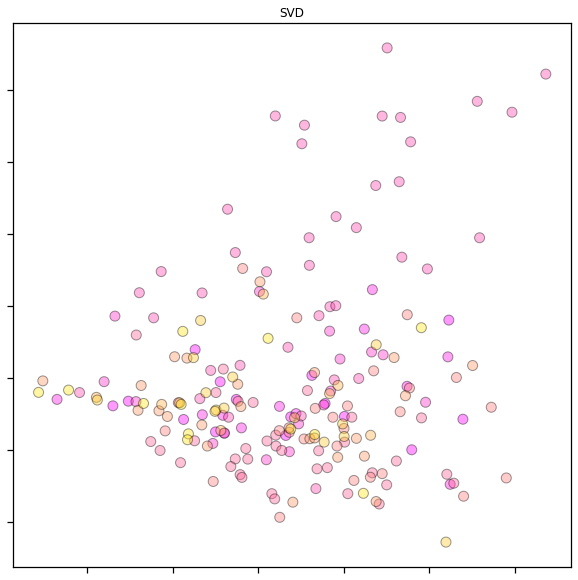

In [14]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

And here is NMF's version:

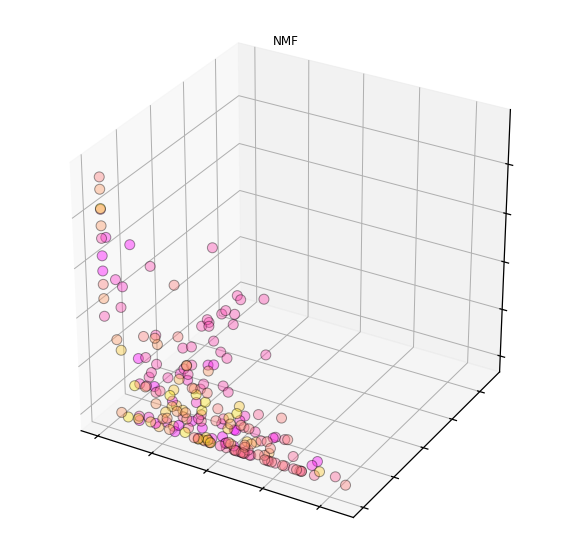

In [15]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

In [16]:
from sklearn.manifold import TSNE

?TSNE

# Latent Dimensions II: Clustering

In [17]:
from sklearn.cluster import KMeans, AgglomerativeClustering

k = 16

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

Wall time: 24.5 s


Let's start clustering with a random sample of points:

In [18]:
sample = np.random.choice(len(X2), replace=False, size=8000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

Wall time: 35 s


In [19]:
agg_sample_ids

array([13, 13, 13, ...,  0,  3,  3], dtype=int64)

We can get the best of both worlds by initializing k-means with centroids we found from agglomerative clustering. First, let's get the centroid/average of each cluster:

In [20]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(16, 300)


Now we can initialize the k-means algorithm with the agglomerative cluster centroids as starting points:

In [21]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2)

C:\Users\Tiziano\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
<timed eval>:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


Wall time: 2.29 s


KMeans(init=array([[ 0.15339219,  0.01317924,  0.08829383, ..., -0.00373739,
        -0.00027579,  0.00191462],
       [ 0.14429917, -0.04660032,  0.01423058, ..., -0.00339775,
         0.00079511, -0.00135713],
       [ 0.15937783, -0.00311446, -0.04905641, ..., -0.0018507 ,
        -0.00057341, -0.0002416 ],
       ...,
       [ 0.1718252 , -0.06964276, -0.04429304, ..., -0.00272117,
         0.00042603,  0.00198614],
       [ 0.13520215,  0.04819634, -0.04313083, ...,  0.00604105,
        -0.0021853 , -0.0024315 ],
       [ 0.17255636, -0.03375671, -0.04288822, ..., -0.0063743 ,
         0.00150161, -0.00028064]]),
       n_clusters=16, n_jobs=-1)

We can now use the cluster IDs to plot the data in three dimensions:

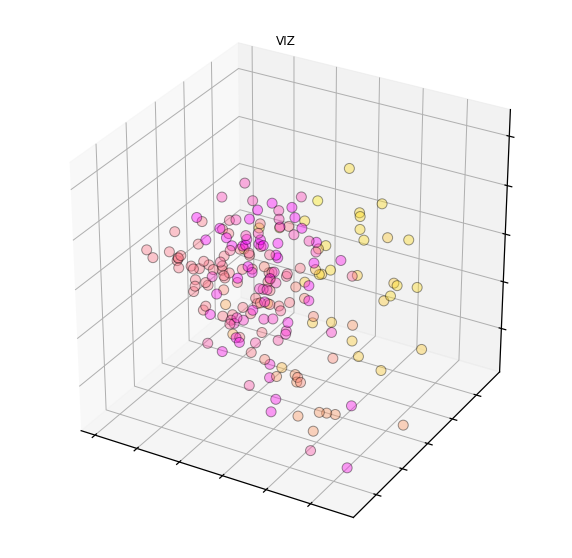

In [22]:
plot_sample = np.random.choice(len(X2), replace=False, size=200)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

… and in two dimensions:

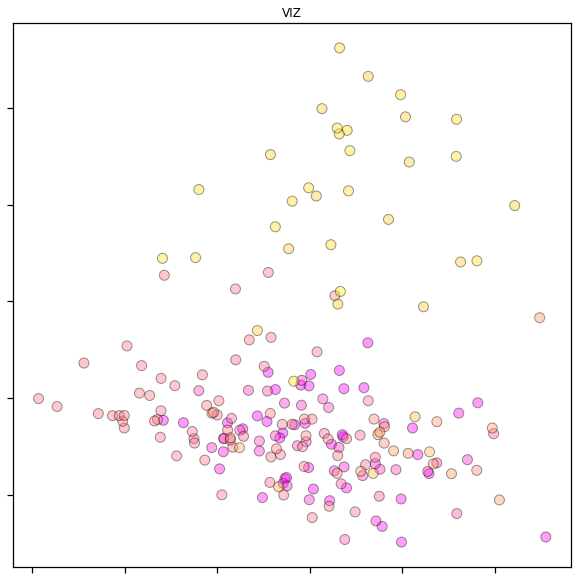

In [23]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

Compare that to the sample we used for agglomerative clustering:

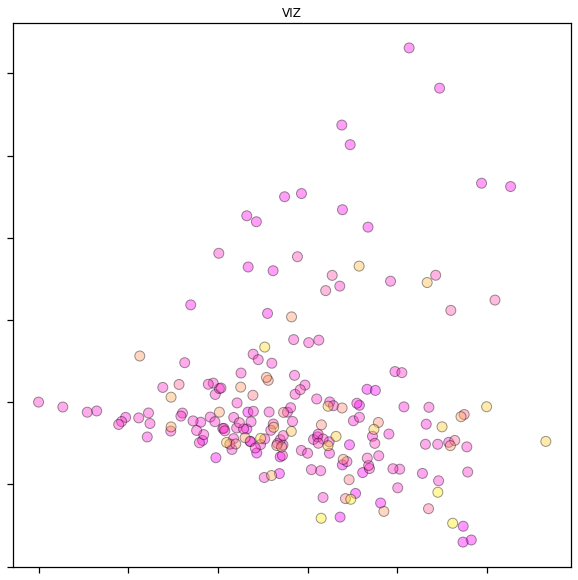

In [24]:
plot_vectors(X2[sample[:200]], labels=agg_sample_ids[:200], dimensions=2)

## Evaluating clusters

To choose the best number of clusters, we can fit various models with different numbers of components and observe the resulting silhouette score.

20 0.012826344874351598
21 0.012852997400876951
22 0.013912193261645164
23 0.014693712470546533
24 0.013413486385266484
25 0.01389686732764635


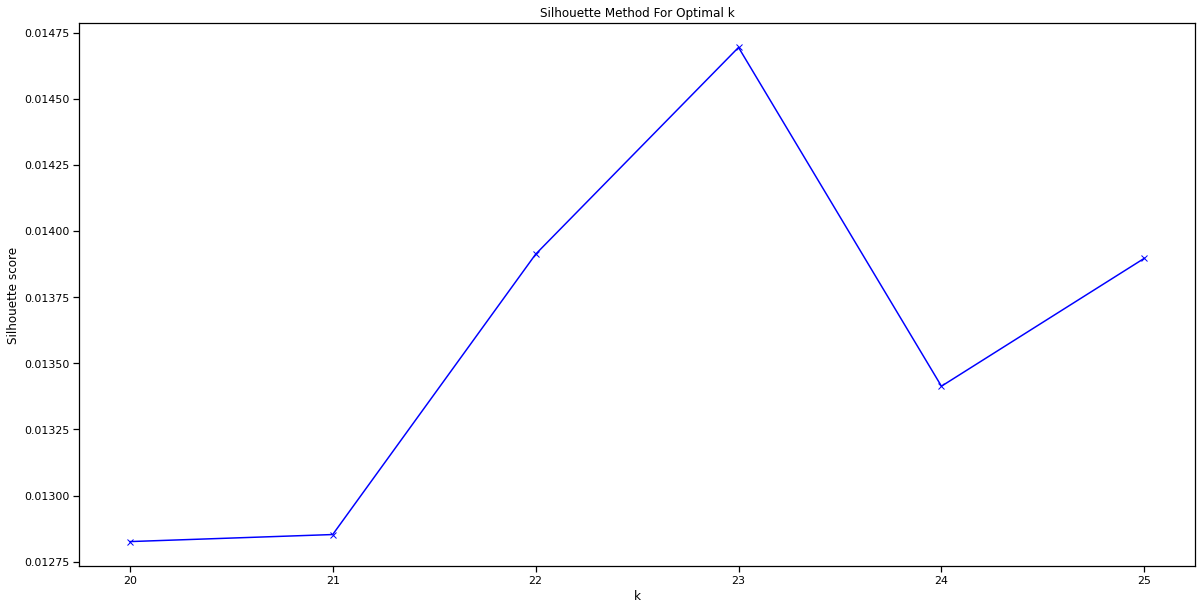

In [25]:
from sklearn.metrics import silhouette_score

silhouettes = []

K = range(20, 26)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
#     agg_centroids = np.array([X2[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
#                            for k in range(c)])

#     kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
#     kmeans_ids = kmeans_clustering.fit_predict(X2)
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()